In [1]:
%matplotlib inline

In [4]:
# %load svg_utils.py
import math
import os
import json
import xml.etree.ElementTree as ET
import requests
from bs4 import BeautifulSoup
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import rgb2hex
import numpy as np
import data_processing as data
import HBA_analysis as hba


def get_ontology(json_file='./data/ontology.json', atlas_id=265297125, graph_id=10):
    if os.path.exists(json_file):
        with open(json_file) as data_file:
            ontology = json.load(data_file)
    else:
        query_url = "http://api.brain-map.org/api/v2/structure_graph_download/{}.json".format(graph_id)
        r = requests.get(query_url)
        response = r.json()
        ontology = response['msg'][0]
        # dump out the ontology to a file
        with open(json_file, 'w') as outfile:
            json.dump(ontology, outfile)

    return ontology


def find_structure(self, attr, value):
    # function to find structure in ontology by attribute
    if self[attr] == value:
        return self
    else:
        for child in self['children']:
            match = find_structure(child, attr, value)
            if match:
                return match


def get_sIDs_in_SVG(svg_filename, ontology):
    # function to parse SVG and return a dict with sID as key and value is structure_name
    ns = {'svg':'http://www.w3.org/2000/svg'}
    structures_names = {}

    with open(svg_filename, 'r') as svg:
            doc = ET.parse(svg)
            root = doc.getroot()

            for elem in root.iter():
                # if this is path element and it has a structure_id
                # add structure_id to structures dictionary if it doesn't already exist
                if elem.tag == '{%s}%s' % (ns['svg'], 'path'):
                    if 'structure_id' in elem.attrib:
                        s_id = int(elem.attrib['structure_id'])
                        # is there a need for structures_names dict? would a list of sIDs suffice?
                        # could remove the need for ontology in the function if simply append s_id to a list
                        if s_id not in structures_names:
                            srec = find_structure(ontology, 'id', int(s_id))
                            structures_names[s_id] = srec['name']
    return structures_names


def find_children_sID(self, attr, value):
    # function to find structure IDs of the children of a given structure
    children_sID = []
    reduced_onto = find_structure(self, attr, value)
    for child in reduced_onto['children']:
        children_sID.append(child['id'])
    return children_sID


def roll_up(sID_list, ontology, HBA_lookup, AUC_vals=None):
    if AUC_vals is None:
        AUC_vals = []
    for sID in sID_list:
        # if the structure with sID is found in HBA_lookup
        if HBA_lookup[HBA_lookup.id == float(sID)].shape[0] > 0:
            value = float(HBA_lookup[HBA_lookup.id == float(sID)].loc[:,'AUROC'])
            AUC_vals.append(value)
        elif len(find_children_sID(ontology, 'id', sID)) > 0:
            # the sID was not found in the results table
            # get a list of sIDs of the children of the structure of interest
            children_sIDs = find_children_sID(ontology, 'id', sID)
            roll_up(children_sIDs, ontology, HBA_lookup, AUC_vals)
            #print(f'sID ({sID}) not found in table, rolling up values from children structures {children_sIDs}')
        else:
            # the structure was not found in HBA_lookup, nor were any of its children
            # get the values of parent structure

            # get parent sID
            structure_info = find_structure(ontology, 'id', sID)
            parent_sID = structure_info['parent_structure_id']
            #print(f'sID: {sID} not found in lookup, getting values from parent: {parent_sID}')
            # get AUC val for that parent sID
            try:
                value = float(HBA_lookup[HBA_lookup.id == float(parent_sID)].loc[:,'AUROC'])
                AUC_vals.append(value)
            except TypeError:
                pass
                # print('No children to roll-up AUC values or parent to inherit AUC val from for sID: {}'.format(sID))
    return AUC_vals


def get_AUC_vals_for_sIDs(sIDs, ontology, HBA_lookup):
    AUC_vals = {}

    for sID in sIDs:
        children_auc_vals = roll_up([sID], ontology, HBA_lookup)
        AUC_vals[sID] = np.mean(children_auc_vals)

    return AUC_vals


def convert_AUCvals_to_hex(sID_AUC_map, cmap='RdBu_r', generate_cbar=False): #'bwr'
    centered_vals = np.abs(np.asarray(list(sID_AUC_map.values())) - 0.5)
    #drop nans
    centered_vals = centered_vals[~np.isnan(centered_vals)]
    extreme_val = max(centered_vals)
    #extreme_val = max(np.abs(np.asarray(list(sID_AUC_map.values())) - 0.5))

    norm = mpl.colors.Normalize(vmin=0.5 - extreme_val , vmax=0.5 + extreme_val)
    color_map = plt.cm.get_cmap('{}'.format(cmap))
    sID_hex_map = {}
    for key, AUC_value in sID_AUC_map.items():
        #print('AUC: {} and normed: {}'.format(AUC_value, norm(AUC_value)))
        #normalized_value = norm(AUC_value)
        if math.isnan(AUC_value):
            colour = '#FFFFFF'
        else:
            colour = color_map(norm(AUC_value))

        sID_hex_map[key] = rgb2hex(colour)

    if generate_cbar:
        fig, ax = plt.subplots(figsize=(1, 8))
        cbar = mpl.colorbar.ColorbarBase(ax, cmap=color_map,norm=norm)
                                 #orientation='horizontal')
        cbar.set_label('AUROC', size=12)
        #fig.subplots_adjust(bottom=0.2)
        #fig.tight_layout()

        return sID_hex_map, fig

    return sID_hex_map


def modify_structure_color(input_svg_file, lookup_table, output_file):#, cbar_file=None):
    # function to modify the colour of a structure in the SVG
    with open(output_file, 'w') as outfile, open(input_svg_file, 'r') as infile:
        # parse the svg file
        soup = BeautifulSoup(infile, 'xml')

        for desc in soup.descendants:
            try:
                attributes = desc.attrs
                try:
                    sID = int(attributes['structure_id'])
                    #import pdb
                    #pdb.set_trace()
                    #print(sID)
                    # need a special rule for white matter of forebrain
                    if sID == 9219: # 9219 = sID of telencephalic whitematter
                        attributes['style'] = 'stroke:black;fill:{}'.format('#FFFFFF') #FFC0CB
                    #elif sID in lookup_table.id:
                    elif lookup_table.id.isin([sID]).any():
                        hex_color = lookup_table[lookup_table.id == sID].hex_color.values[0]
                        #import pdb; pdb.set_trace()
                        print(f"hex colour is {hex_color}")
                        attributes['style'] = 'stroke:black;fill:{}'.format(hex_color)
                        print(attributes['style'])
                    else:
                        #continue
                        attributes['style'] = 'stroke:black;fill:{}'.format('#FFFFFF')
                except (KeyError, AttributeError):
                    #print('no attributes for this descendant:', desc)
                    continue
            except AttributeError:
                #print('no stucture attributes for this descendant:', attributes)
                continue
        print(f'Writing modified svg to {output_file}')
        outfile.write(str(soup))
        #return outfile


def convert_to_hex(auc, cmap, norm):
    # helper to be applied on lookup table AUROC values
    cmap = plt.cm.get_cmap(cmap)
    color = cmap(norm(auc))
    hex_color = rgb2hex(color)
    
    return hex_color


def create_auc_lookup(exp_df, gene_list, ontology):
    if ontology == 'adult':
        # modify the default ontology to remove left/right from structure names
        ontology_df = pd.read_csv('./data/raw/allen_HBA/normalized_microarray_donor10021/Ontology.csv')
        # name column to be the same as fetal ontology
        ontology_df['structure_name'] = ontology_df.name.apply(data.strip_left_right)

    elif ontology == 'fetal':
        # not all structures are contained in any single ontology.csv for fetal brains
        # concatenate all and drop duplicated rows
        fetal_ontology1 = pd.read_csv('./data/raw/allen_human_fetal_brain/lmd_matrix_12566/columns_metadata.csv')
        fetal_ontology2 = pd.read_csv('./data/raw/allen_human_fetal_brain/lmd_matrix_12690/columns_metadata.csv')
        fetal_ontology3 = pd.read_csv('./data/raw/allen_human_fetal_brain/lmd_matrix_12840/columns_metadata.csv')
        fetal_ontology4 = pd.read_csv('./data/raw/allen_human_fetal_brain/lmd_matrix_14751/columns_metadata.csv')
        ontology_df = pd.concat([fetal_ontology1, fetal_ontology2, fetal_ontology3, fetal_ontology4])
        ontology_df.drop_duplicates(subset=['structure_id'], inplace=True)
        # rename id column to be same as with adult ontology
        ontology_df.rename(columns={'structure_id': 'id'}, inplace=True)

    # create dicts that map from sID to structure names and inverse
    # this isn't used?
    sID_to_brainstructure = ontology_df.set_index('id').loc[:, 'structure_name'].to_dict()
    brainstructure_to_sID = {}
    for k, v in sID_to_brainstructure.items():
        brainstructure_to_sID[v] = brainstructure_to_sID.get(v, [])
        brainstructure_to_sID[v].append(k)

    # map sIDs to results table
    results = hba.generate_stats_table(exp_df, gene_list)
    results = results.reset_index()
    results = results.rename(columns={'index': 'structure'})
    results['id'] = results.structure.map(brainstructure_to_sID)

    # expand rows where there are multiple sIDs for each structure, then merge results
    HBA_lookup = results.set_index('structure').id.apply(pd.Series).stack().reset_index(level=1, drop=True)
    #HBA_lookup = HBA_lookup.reset_index(name='id').merge(ontology_df[['id', 'parent_structure_id']], on='id')
    HBA_lookup = HBA_lookup.reset_index(name='id').merge(ontology_df[['id']], on='id')
    HBA_lookup = HBA_lookup.merge(results.drop('id', axis=1), on='structure')
    HBA_lookup.id = pd.to_numeric(HBA_lookup.id, errors='ignore')

    # generate column with hex colour based off AUROC
    extreme_val = np.max(np.abs(HBA_lookup.AUROC - 0.5))
    norm = mpl.colors.Normalize(vmin=0.5 - extreme_val, vmax=0.5 + extreme_val)
    HBA_lookup['hex_color'] = HBA_lookup.AUROC.apply(convert_to_hex, cmap='RdBu_r', norm=norm)
    return HBA_lookup


def clean_SVG(svg_filename, output_filename):
    with open(svg_filename, 'r') as svg, open(output_filename, 'w') as outfile:
        soup = BeautifulSoup(svg, 'xml')
        to_remove = soup.find_all(attrs={"graphic_group_label": ["Atlas - Human Sulci", "Atlas - Human Hotspots"]})
        for r in to_remove:
            r.decompose()
        
        print(f'Writing cleaned svg to {output_filename}')
        outfile.write(str(soup))


def modify_svg(svg_file, svg_output, graph_id, lookup_table, cbar_file=None):
    if graph_id == 'adult':
        ontology = get_ontology(json_file='./data/ontology.json', atlas_id=265297125, graph_id=10)
    elif graph_id == 'fetal':
        ontology = get_ontology(json_file='./data/fetal21ontology.json', atlas_id=3, graph_id=16)
    elif graph_id == 'fetal_brainstem':
        ontology = get_ontology(json_file='./data/fetal_brainstem_ontology.json', atlas_id=287730656, graph_id=16)

    #svg_sIDs = get_sIDs_in_SVG(svg_file, ontology)

    #sID_auc_map = get_AUC_vals_for_sIDs(svg_sIDs.keys(), ontology, lookup_table)

    #svg_output =
    #modify_structure_color(svg_file, sID_auc_map, svg_output)#, cbar_file=cbar_file)
    modify_structure_color(svg_file, lookup_table, svg_output)#, cbar_file=cbar_file)

    #return svg_output


def merge_dicts(*dict_args):
    """
    Given any number of dicts, shallow copy and merge into a new dict,
    precedence goes to key value pairs in latter dicts.
    """
    result = {}
    for dictionary in dict_args:
        result.update(dictionary)
    return result


def modify_svgs(svg_files, output_dir, graph_id, lookup_table, cbar_file=None):
    if graph_id == 'adult':
        ontology = get_ontology(json_file='./data/ontology.json', atlas_id=265297125, graph_id=10)
    elif graph_id == 'fetal':
        ontology = get_ontology(json_file='./data/fetal21ontology.json', atlas_id=3, graph_id=16)
    elif graph_id == 'fetal_brainstem':
        ontology = get_ontology(json_file='./data/fetal_brainstem_ontology.json', atlas_id=287730656, graph_id=16)

    sIDs_list = []
    # get all list of all sIDs present in all SVGs first
    
    for svg in svg_files:
        print('svg file location: ', svg)
        svg_sIDs = get_sIDs_in_SVG(svg, ontology)
        sIDs_list.append(svg_sIDs)
        
    all_sIDs = merge_dicts(*sIDs_list)

    #sID_auc_map = get_AUC_vals_for_sIDs(svg_sIDs.keys(), ontology, lookup_table)
    sID_auc_map = get_AUC_vals_for_sIDs(all_sIDs.keys(), ontology, lookup_table)

    #sID_hex_map, cbar = convert_AUCvals_to_hex(sID_auc_map, generate_cbar=True)

    for svg in svg_files:
        output_file = output_dir / 'colorized_{}'.format(svg.name)
        modify_structure_color(svg, sID_auc_map, output_file, cbar_file=cbar_file)



In [5]:
gabra5 = pd.Series(['GABRA5'])

In [6]:
adult_exp = data.get_dataset(dataset='adult', probes_strategy='reannotator')
fetal_exp = data.get_dataset(dataset='fetal', probes_strategy='reannotator')

Processed HBA brain dataset found locally. Loading from data/processed/adult_brainarea_vs_genes_exp_reannotator.tsv
Processed HBA brain dataset found locally. Loading from data/processed/fetal_brainarea_vs_genes_exp_reannotator.tsv


In [7]:
adult_exp.loc['GABRA5', :].sort_values()

X, lateral hemisphere                                   -1.987293
V, lateral hemisphere                                   -1.973519
IV, paravermis                                          -1.953258
VI, paravermis                                          -1.924426
VIIIB, lateral hemisphere                               -1.918673
VIIIA, paravermis                                       -1.888335
III, lateral hemisphere                                 -1.885984
V, paravermis                                           -1.873671
X, paravermis                                           -1.851207
III, paravermis                                         -1.833451
VIIB, paravermis                                        -1.812311
Crus II, lateral hemisphere                             -1.811876
Crus II, paravermis                                     -1.805073
IX, lateral hemisphere                                  -1.801018
VIIIA, lateral hemisphere                               -1.799949
VIIIA     

In [8]:
ontology = get_ontology(json_file='./data/ontology.json', atlas_id=265297125, graph_id=10)

In [9]:
human_diagram = ('./figures/human_diagram.svg')

In [10]:
svg_sIDs = get_sIDs_in_SVG(human_diagram, ontology)

In [27]:
svg_sIDs

{4010: 'precentral gyrus',
 4021: 'superior frontal gyrus',
 4028: 'middle frontal gyrus',
 4038: 'inferior frontal gyrus, triangular part',
 4041: 'inferior frontal gyrus, opercular part',
 4044: 'inferior frontal gyrus, orbital part',
 4047: 'gyrus rectus',
 4050: 'medial orbital gyrus',
 4053: 'anterior orbital gyrus',
 4056: 'posterior orbital gyrus',
 4059: 'lateral orbital gyrus',
 4062: 'subcallosal cingulate gyrus',
 4065: 'paraterminal gyrus',
 4068: 'parolfactory gyri',
 4071: 'paracentral lobule, anterior part',
 4078: 'frontal operculum',
 4085: 'postcentral gyrus',
 4096: 'superior parietal lobule',
 4104: 'supramarginal gyrus',
 4111: 'angular gyrus',
 4118: 'precuneus',
 4125: 'paracentral lobule, posterior part',
 4133: 'superior temporal gyrus',
 4140: 'middle temporal gyrus',
 4147: 'inferior temporal gyrus',
 4156: 'fusiform gyrus',
 4165: "Heschl's gyrus",
 4168: 'transverse gyri',
 4171: 'planum temporale',
 4174: 'temporal pole',
 4177: 'planum polare',
 4181: 'oc

In [11]:
svg_info = pd.Series(svg_sIDs).reset_index(name='structure').rename(columns={'index': 'id'})

In [12]:
adult_exp.loc['GABRA5', :].shape

(232,)

In [13]:
svg_info.shape

(117, 2)

In [14]:
svg_info

,id,structure
0,4010,precentral gyrus
1,4021,superior frontal gyrus
2,4028,middle frontal gyrus
3,4038,"inferior frontal gyrus, triangular part"
4,4041,"inferior frontal gyrus, opercular part"
5,4044,"inferior frontal gyrus, orbital part"
6,4047,gyrus rectus
7,4050,medial orbital gyrus
8,4053,anterior orbital gyrus
9,4056,posterior orbital gyrus


In [15]:
# create expression lookup table
ontology_df = pd.read_csv('./data/raw/allen_HBA/normalized_microarray_donor10021/Ontology.csv')
ontology_df['structure_name'] = ontology_df.name.apply(data.strip_left_right)
sID_to_brainstructure = ontology_df.set_index('id').loc[:, 'structure_name'].to_dict()
brainstructure_to_sID = {}
for k, v in sID_to_brainstructure.items():
    brainstructure_to_sID[v] = brainstructure_to_sID.get(v, [])
    brainstructure_to_sID[v].append(k)

results = adult_exp.loc['GABRA5', :]
results = results.reset_index(name='expression').rename(columns={'index': 'structure'})

In [16]:
results['id'] = results.structure.map(brainstructure_to_sID)

expression_lookup = results.set_index('structure').id.apply(pd.Series).stack().reset_index(level=1, drop=True)
expression_lookup = expression_lookup.reset_index(name='id').merge(ontology_df[['id']], on='id')
expression_lookup = expression_lookup.merge(results.drop('id', axis=1), on='structure')

,structure,id,expression
0,CA1 field,12892,1.286722
1,CA1 field,4254,1.286722
2,CA1 field,4263,1.286722
3,CA2 field,12893,1.328028
4,CA2 field,4255,1.328028
5,CA2 field,4264,1.328028
6,CA3 field,12894,1.214189
7,CA3 field,4256,1.214189
8,CA3 field,4265,1.214189
9,CA4 field,12895,1.017323


In [17]:
expression_lookup.head()

,structure,id,expression
0,CA1 field,12892,1.286722
1,CA1 field,4254,1.286722
2,CA1 field,4263,1.286722
3,CA2 field,12893,1.328028
4,CA2 field,4255,1.328028


In [18]:
## modified previous rollup function to use expression values instead of AUC values

def roll_up(sID_list, ontology, HBA_lookup, AUC_vals=None):
    if AUC_vals is None:
        AUC_vals = []
    for sID in sID_list:
        # if the structure with sID is found in HBA_lookup
        if HBA_lookup[HBA_lookup.id == float(sID)].shape[0] > 0:
            value = float(HBA_lookup[HBA_lookup.id == float(sID)].loc[:,'expression'])
            AUC_vals.append(value)
        elif len(find_children_sID(ontology, 'id', sID)) > 0:
            # the sID was not found in the results table
            # get a list of sIDs of the children of the structure of interest
            children_sIDs = find_children_sID(ontology, 'id', sID)
            roll_up(children_sIDs, ontology, HBA_lookup, AUC_vals)
            #print(f'sID ({sID}) not found in table, rolling up values from children structures {children_sIDs}')
        else:
            # the structure was not found in HBA_lookup, nor were any of its children
            # get the values of parent structure

            # get parent sID
            structure_info = find_structure(ontology, 'id', sID)
            parent_sID = structure_info['parent_structure_id']
            #print(f'sID: {sID} not found in lookup, getting values from parent: {parent_sID}')
            # get AUC val for that parent sID
            try:
                value = float(HBA_lookup[HBA_lookup.id == float(parent_sID)].loc[:,'expression'])
                AUC_vals.append(value)
            except TypeError:
                pass
                # print('No children to roll-up AUC values or parent to inherit AUC val from for sID: {}'.format(sID))
    return AUC_vals

In [20]:
def get_exp_vals_for_sIDs(sIDs, ontology, HBA_lookup):
    AUC_vals = {}

    for sID in sIDs:
        children_auc_vals = roll_up([sID], ontology, HBA_lookup)
        AUC_vals[sID] = np.mean(children_auc_vals)

    return AUC_vals

In [21]:
expression_vals = get_exp_vals_for_sIDs(svg_sIDs.keys(), ontology=ontology, HBA_lookup=expression_lookup)

In [22]:
def convert_expression_vals_to_hex(sID_exp_map, cmap='RdBu_r', generate_cbar=False): #'bwr'
    centered_vals = np.abs(np.asarray(list(sID_exp_map.values())))
    #drop nans
    centered_vals = centered_vals[~np.isnan(centered_vals)]
    extreme_val = max(centered_vals)
    #extreme_val = max(np.abs(np.asarray(list(sID_AUC_map.values())) - 0.5))

    norm = mpl.colors.Normalize(vmin=0 - extreme_val , vmax=0 + extreme_val)
    color_map = plt.cm.get_cmap('{}'.format(cmap))
    sID_hex_map = {}
    for key, exp_value in sID_exp_map.items():
        #print('AUC: {} and normed: {}'.format(AUC_value, norm(AUC_value)))
        #normalized_value = norm(AUC_value)
        if math.isnan(exp_value):
            colour = '#FFFFFF'
        else:
            colour = color_map(norm(exp_value))

        sID_hex_map[key] = rgb2hex(colour)

    if generate_cbar:
        fig, ax = plt.subplots(figsize=(1, 8))
        cbar = mpl.colorbar.ColorbarBase(ax, cmap=color_map,norm=norm)
                                 #orientation='horizontal')
        cbar.set_label('expression', size=12)

        return sID_hex_map, fig

    return sID_hex_map

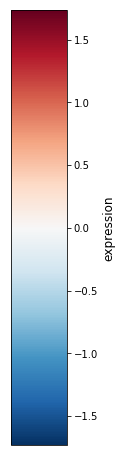

In [23]:
sID_hex_map, cbar = convert_expression_vals_to_hex(expression_vals, generate_cbar=True)

In [24]:
len(expression_vals)

117

In [26]:
svg_output = modify_structure_color(human_diagram, expression_vals, 'GABRA5.svg')

Writing modified svg to GABRA5.svg


In [38]:
svg_expression_vals = pd.Series(expression_vals, name='exp').reset_index().rename(columns={'index': 'id'})

In [51]:
expression_table = pd.Series(expression_vals, name='exp').reset_index().rename(columns={'index': 'id'}).merge(svg_info, on='id')

In [54]:
expression_table.sort_values('exp', ascending=False).to_csv('human_diagram_GABRA5_expression.csv', index=None)

In [56]:
adult_exp.loc['GABRA5', :].to_csv('HBA_GABRA5_expression.csv')